In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

# from tensorflow.python.client import device_lib 
# device_lib.list_local_devices()

# print the tensorflow version
print('Tensorflow version is ' + str(tf.__version__))

You have GPU access
Wed Jan 25 15:45:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:00:05.0 Off |                  N/A |
| 29%   39C    P2    52W / 250W |    335MiB / 11264MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

In [2]:
import tensorflow as tf
from tensorflow.image import resize_with_crop_or_pad
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
# import tensorflow_addons as tfa

import tensorboard as tb
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from sklearn.metrics import balanced_accuracy_score

import matplotlib.cm as cm
from IPython.display import Image, display

from pathlib import Path
import pickle
import numpy as np
import datetime, os
import glob
from math import exp, log, pow
# from PIL import Image
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

tf.random.set_seed(42)
np.random.seed(42)

UPLOAD_LOGS = True
RELOAD_MODEL = False
MODEL_NAME = "SDH16K_GPU_WITHAUG"

BATCH_SIZE = 32
EPOCH_OPTI_LR = 100
OPTI_START_LR = 1e-7
MIN_LR = 1e-7
MAX_LR = 1e-5

EARLY_STOPPING_PATIENCE = 10

BASE_FOLDER = "/home/meyer/code-project/MyoQuant-SDH-Train/data/"
LOG_DIR = "/home/meyer/code-project/MyoQuant-SDH-Train/logs"

SUB_FOLDERS = ["control", "sick"]
MODEL_PATH = os.path.join(BASE_FOLDER, "results", MODEL_NAME)
Path(MODEL_PATH).mkdir(parents=True, exist_ok=True)

logdir = os.path.join(LOG_DIR, datetime.datetime.now().strftime(MODEL_NAME+"_%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

def generate_dataset(folder, sub_folders=["control", "inter", "sick"]):
    n_elem = 0
    for sub_folder in sub_folders:
      n_elem += len(glob.glob(os.path.join(folder, sub_folder, "*.tif")))
    
    images_array = np.empty(shape=(n_elem, 256, 256, 3), dtype=np.uint8)
    labels_array = np.empty(shape=n_elem, dtype=np.uint8)
    counter = 0
    for index, sub_folder in enumerate(sub_folders):
      path_files = os.path.join(folder, sub_folder, "*.tif")
      for img in glob.glob(path_files):
          im = img_to_array(image.load_img(img))
          # im_resized = image.smart_resize(im, (256, 256))
          im_resized = tf.image.resize(im, (256,256))
          images_array[counter] = im_resized
          labels_array[counter] = index
          counter += 1
    return images_array, labels_array

def scale_fn(x):
  # return 1.0 # Triangular Scaling Method
  return 1 / (2.0 ** (x - 1)) # Triangular2 Scaling method


def get_inter_unsure_img(BASE_FOLDER):
    n_unsure = len(glob.glob(BASE_FOLDER+"Unsure/*.tif"))
    n_intermediate = len(glob.glob(BASE_FOLDER+"Intermediate/*.tif"))
    
    unsure_images = np.empty(shape=(n_unsure, 256, 256, 3), dtype=np.uint8)
    intermediate_images = np.empty(shape=(n_intermediate, 256, 256, 3), dtype=np.uint8)

    counter = 0
    for img in glob.glob(BASE_FOLDER+"Unsure/*.tif"):
        im = img_to_array(image.load_img(img))
        # im_resized = image.smart_resize(im, (256, 256))
        im_resized = tf.image.resize(im, (256,256))
        unsure_images[counter] = im_resized
        counter += 1
    
    counter = 0
    for img in glob.glob(BASE_FOLDER+"Intermediate/*.tif"):
        im = img_to_array(image.load_img(img))
        # im_resized = image.smart_resize(im, (256, 256))
        im_resized = tf.image.resize(im, (256,256))
        intermediate_images[counter] = im_resized
        counter += 1


    return unsure_images, intermediate_images

# GRAD-CAM
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img*255
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

{0: 0.6593016912165849, 1: 2.069349315068493}


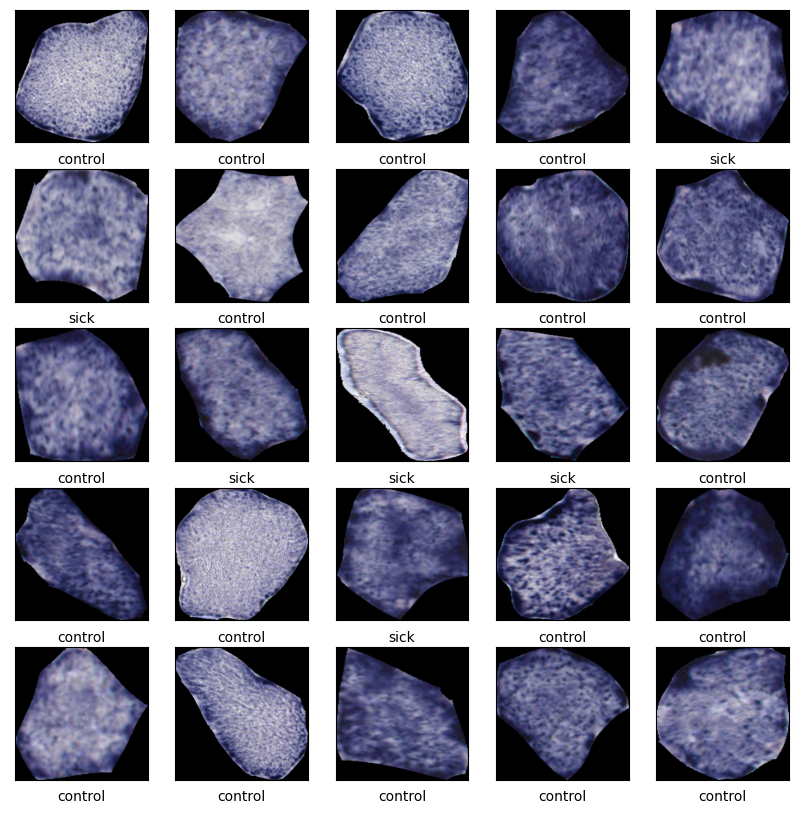

In [3]:
train_images, train_labels = generate_dataset(os.path.join(BASE_FOLDER, "train"), sub_folders=SUB_FOLDERS)
val_images, val_labels = generate_dataset(os.path.join(BASE_FOLDER, "validation"), sub_folders=SUB_FOLDERS)
test_images, test_labels = generate_dataset(os.path.join(BASE_FOLDER, "test"), sub_folders=SUB_FOLDERS)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).repeat(1)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).shuffle(10000).repeat(1)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(10000).repeat(1) 

data_augmentation = tf.keras.Sequential([
  layers.RandomBrightness(factor=0.2), # Not avaliable in tensorflow 2.8
  layers.RandomContrast(factor=0.2),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3, fill_mode="constant"),
  layers.RandomZoom(.2, .2, fill_mode="constant"),
  layers.RandomTranslation(0.2, .2,fill_mode="constant"),
])

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(1)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(1)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(1)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

class_weights_numpy = np.unique(train_labels, return_counts=True)
n_train = len(train_labels)
class_weights = dict()
for index, folder in enumerate(SUB_FOLDERS):
  class_weights[class_weights_numpy[0][index]] = (1/class_weights_numpy[1][index])*(n_train/2.0)

print(class_weights)

plt.figure(figsize=(10,10))
counter = 0

for i in np.random.choice(range(len(train_images)),25):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(SUB_FOLDERS[train_labels[i]])
    counter +=1
plt.show()

In [4]:
data_augmentation = tf.keras.Sequential([
  layers.RandomBrightness(factor=0.2, input_shape=(None, None, 3)), # Not avaliable in tensorflow 2.8
  layers.RandomContrast(factor=0.2),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3, fill_mode="constant"),
  layers.RandomZoom(.2, .2, fill_mode="constant"),
  layers.RandomTranslation(0.2, .2,fill_mode="constant"),
  layers.Resizing(256, 256, interpolation="bilinear", crop_to_aspect_ratio=True), 
  layers.Rescaling(scale=1./127.5, offset=-1), # For [-1, 1] scaling
])

# My ResNet50V2
model = models.Sequential()
model.add(data_augmentation)
model.add(
    ResNet50V2(
    include_top=False,
    input_shape=(256,256,3),
    pooling="avg",
  )
)
model.add(layers.Flatten())
#model.add(layers.Dense(512))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(SUB_FOLDERS), activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


In [5]:
# Find min max LR
"""
def scheduler(epoch, lr):
    return lr*exp(log(pow(10,8))/EPOCH_OPTI_LR)

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=OPTI_START_LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_images, train_labels, epochs=EPOCH_OPTI_LR, batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels), shuffle=True, class_weight=class_weights, 
                    callbacks=[lr_cb, tensorboard_cb])

loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate_range = [OPTI_START_LR]
for epoch in range(EPOCH_OPTI_LR-1):
  learning_rate_range.append(learning_rate_range[epoch] * exp(log(pow(10,8))/EPOCH_OPTI_LR))

plt.figure(figsize=(16, 8))

plt.subplot(1, 1, 1)
plt.plot(learning_rate_range, loss, label='Training Loss')
plt.plot(learning_rate_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xscale('log')
plt.savefig(os.path.join(MODEL_PATH, "curve_findLR.png"), dpi=300)
plt.show()
"""

'\ndef scheduler(epoch, lr):\n    return lr*exp(log(pow(10,8))/EPOCH_OPTI_LR)\n\nmodel.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=OPTI_START_LR),\n              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=[\'accuracy\'])\n\nlr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)\nhistory = model.fit(train_images, train_labels, epochs=EPOCH_OPTI_LR, batch_size=BATCH_SIZE,\n                    validation_data=(val_images, val_labels), shuffle=True, class_weight=class_weights, \n                    callbacks=[lr_cb, tensorboard_cb])\n\nloss = history.history[\'loss\']\nval_loss = history.history[\'val_loss\']\n\nlearning_rate_range = [OPTI_START_LR]\nfor epoch in range(EPOCH_OPTI_LR-1):\n  learning_rate_range.append(learning_rate_range[epoch] * exp(log(pow(10,8))/EPOCH_OPTI_LR))\n\nplt.figure(figsize=(16, 8))\n\nplt.subplot(1, 1, 1)\nplt.plot(learning_rate_range, loss, label=\'Training Loss\')\nplt.plot(learning_rate_rang

In [6]:
steps_per_epoch = len(train_images) // BATCH_SIZE # Batch size is 32

# Triangular 1Cycle Scheduler and Cosine Scheduler
# clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=MIN_LR,
#     maximal_learning_rate=MAX_LR,
#     scale_fn=scale_fn,
#     step_size= 8 * steps_per_epoch
# )
# cosine_decay = tf.keras.optimizers.schedules.CosineDecayRestarts(
#    TRAIN_LR, 10 * steps_per_epoch, t_mul=1.0, m_mul=1.0, alpha=0.005)

if RELOAD_MODEL:
  print(MODEL_NAME, " reloaded as starting point!")
  model = models.load_model(os.path.join(MODEL_PATH, "model.h5"), custom_objects={"scale_fn": scale_fn})


reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=MIN_LR)

checkpoint_cb = callbacks.ModelCheckpoint(os.path.join(MODEL_PATH, "model.h5"), save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=MAX_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

history = model.fit(train_dataset, epochs=1000, batch_size=BATCH_SIZE,
                    validation_data=val_dataset, shuffle=True, class_weight=class_weights, 
                    callbacks=[reduce_lr, checkpoint_cb, early_stopping_cb, tensorboard_cb])

model = models.load_model(os.path.join(MODEL_PATH, "model.h5"))

with open(os.path.join(MODEL_PATH, "history.pickle"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/1000
378/378 [==============================] - 269s 592ms/step - loss: 0.4675 - accuracy: 0.7528 - val_loss: 0.2711 - val_accuracy: 0.8996 - lr: 1.0000e-05
Epoch 2/1000
378/378 [==============================] - 221s 583ms/step - loss: 0.2632 - accuracy: 0.8980 - val_loss: 0.2524 - val_accuracy: 0.9033 - lr: 1.0000e-05
Epoch 3/1000
378/378 [==============================] - 221s 583ms/step - loss: 0.2395 - accuracy: 0.9048 - val_loss: 0.2245 - val_accuracy: 0.9100 - lr: 1.0000e-05
Epoch 4/1000
378/378 [==============================] - 219s 579ms/step - loss: 0.2218 - accuracy: 0.9143 - val_loss: 0.2246 - val_accuracy: 0.9077 - lr: 1.0000e-05
Epoch 5/1000
378/378 [==============================] - 220s 580ms/step - loss: 0.2068 - accuracy: 0.9192 - val_loss: 0.2053 - val_accuracy: 0.9211 - lr: 1.0000e-05
Epoch 6/1000
378/378 [==============================] - 219s 578ms/step - loss: 0.1954 - accuracy: 0.9201 - val_loss: 0.1832 - val_accuracy: 0.9286 - lr: 1.0000e-05
Epoch 7/10

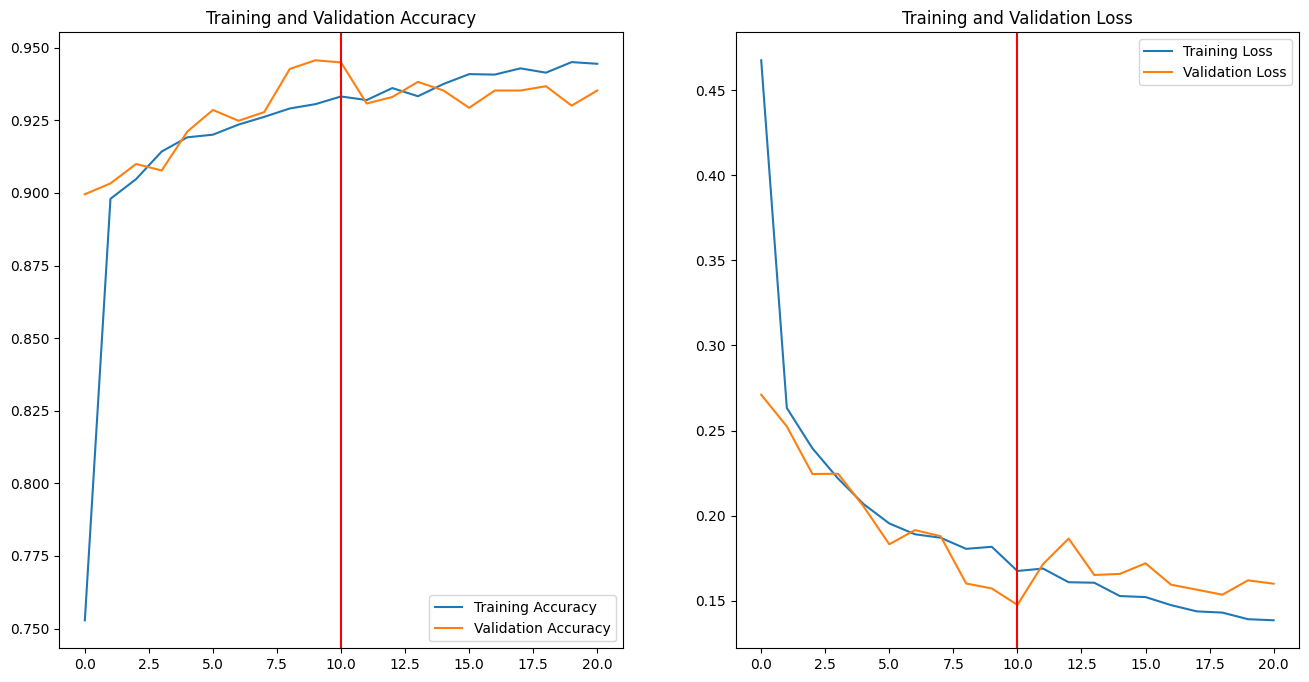

In [7]:
# Acc and Loss Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=len(acc)-EARLY_STOPPING_PATIENCE-1, color="red")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=len(acc)-EARLY_STOPPING_PATIENCE-1, color="red")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(os.path.join(MODEL_PATH, "training_curve.png"), dpi=300)
plt.show()

In [8]:
# Test Evaluation
model = models.load_model(os.path.join(MODEL_PATH, "model.h5"))

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print("Test data results: ")
print(test_acc)

test_proba = model.predict(test_images)
test_classes = test_proba.argmax(axis=-1)
print("Test data results: ")
print(balanced_accuracy_score(test_labels, test_classes))

105/105 - 7s - loss: 0.1569 - accuracy: 0.9315 - 7s/epoch - 66ms/step
Test data results: 
0.931506872177124
105/105 [==============================] - 6s 44ms/step
Test data results: 
0.917506549441024


1/1 [==============================] - 0s 53ms/step


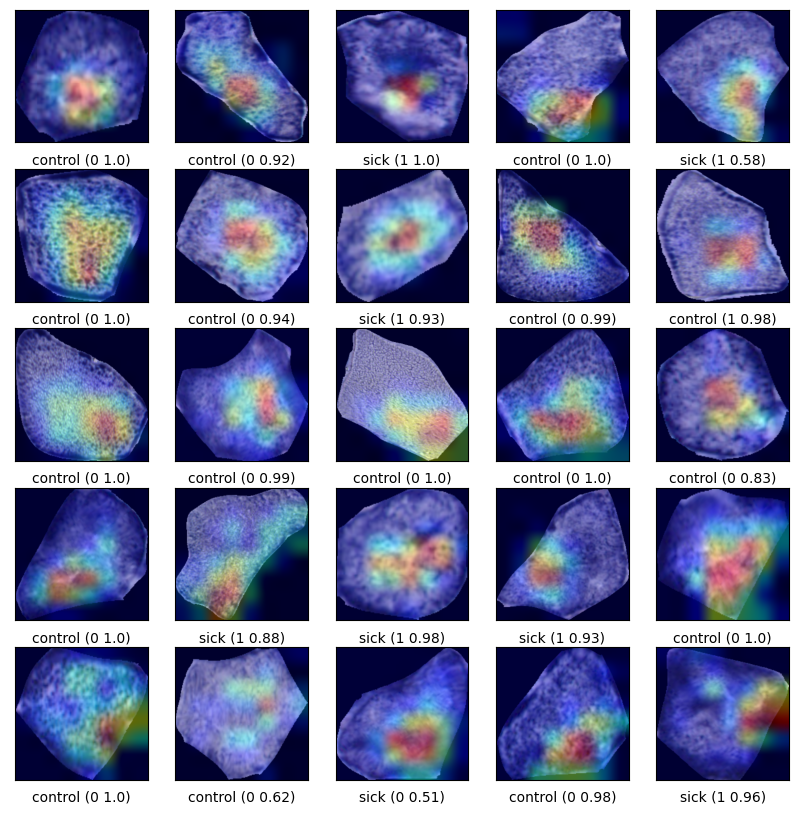

In [9]:
# Generate class activation heatmap
model = models.load_model(os.path.join(MODEL_PATH, "model.h5"))
counter = 0
plt.figure(figsize=(10,10))

for i in np.random.choice(range(len(test_images)),25):
    img_array = np.empty((1, 256, 256, 3))
    img_array[0]=test_images[i]/255.
    predicted_class = model.predict(img_array*255).argmax()
    predicted_proba = round(np.amax(model.predict(img_array*255)), 2)
    heatmap = make_gradcam_heatmap(img_array, model.get_layer("resnet50v2"), "conv5_block3_3_conv") 
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    grad_cam_img = save_and_display_gradcam(img_array[0], heatmap)
    plt.imshow(grad_cam_img)
    xlabel = SUB_FOLDERS[test_labels[i]]+" (" + str(predicted_class) + " " + str(predicted_proba) + ")"
    plt.xlabel(xlabel)
    counter +=1
plt.show()